In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
import multiprocessing as mp 

import pandas
pandas.set_option('display.max_columns', None)

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use(['labstyle.mplstyle']) 

# Importing data

In [2]:
def Plot(x_data, y_data, x_label='', y_label='', xbins=20, hist2d_nbins=200, x_min=None, x_max=None, y_min=None, y_max=None, xlog=True, ylog=True):
    plt.rcParams['figure.figsize'] = [16 , 8]
    fig, axes = plt.subplots(1, 2)
    
    if x_min==None: x_min = np.min(x_data)
    if x_max==None: x_max = np.max(x_data)
    if y_min==None: y_min = np.min(y_data)
    if y_max==None: y_max = np.max(y_data)


    # First Plot
    ax = axes[0]
    ax.set_title(f'Means of {int(xbins)} log-spaced bins')
    bin_edges = np.logspace(start=np.log10(x_min), stop=np.log10(x_max), num=xbins+1)
    statistics = np.zeros(shape=(int(xbins), 5))
    
    for i in range(int(xbins)):
        mask_bin = ((x_data>=bin_edges[i]) & (x_data<bin_edges[i+1]))
        x_temp = np.array(x_data[mask_bin])
        y_temp = np.array(y_data[mask_bin])
        N_temp = int(len(x_temp))
        statistics[i] = np.array([N_temp, 
                                  np.mean(x_temp), 
                                  np.std(x_temp, ddof=1)/np.sqrt(N_temp), 
                                  np.mean(y_temp), 
                                  np.std(y_temp, ddof=1)/np.sqrt(N_temp)])

    ax.errorbar(x=statistics[:,1], 
                y=statistics[:,3], 
                xerr=statistics[:,2], 
                yerr=statistics[:,4], 
                fmt='.', color='blue', ecolor='grey', capsize=4, capthick=1)
    
    x_min_bins = np.min(statistics[:,1])
    x_max_bins = np.max(statistics[:,1])
    y_min_bins = np.min(statistics[:,3])
    y_max_bins = np.max(statistics[:,3])
    
    if xlog==True: 
        ax.set_xscale('log')
        ax.set_xlim(0.5*x_min_bins, 1.5*x_max_bins)
    else: 
        ax.set_xlim(0.99*x_min_bins, 1.01*x_max_bins)
        
    if ylog==True: 
        ax.set_yscale('log')
        ax.set_ylim(0.5*y_min_bins, 1.5*y_max_bins)
    else:
        ax.set_ylim(0.95*y_min_bins, 1.05*y_max_bins)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)


    # Second Plot
    ax = axes[1]
    ax.set_title(f'2-D histogram of the data')
    binx = np.logspace(start=np.log10(x_min), stop=np.log10(x_max), num=hist2d_nbins)
    biny = np.logspace(start=np.log10(y_min), stop=np.log10(y_max), num=hist2d_nbins)
    hist = ax.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
    
    if xlog==True: ax.set_xscale('log')
    if ylog==True: ax.set_yscale('log')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    cax = fig.add_axes([0.91, 0.11, 0.02, 0.77])
    fig.colorbar(hist[3], cax=cax)
    
    
    plt.show()
    
    return fig, axes, statistics, hist

In [3]:
results = Table.read('SDSS_LAB2024_PROFresults.fits', format='fits')
results = results.to_pandas()
results

,id,bayes.attenuation.E_BVs.stellar.young,bayes.attenuation.E_BVs.stellar.young_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sdss.gp,bayes.sdss.gp_err,bayes.sdss.ip,bayes.sdss.ip_err,bayes.sdss.rp,bayes.sdss.rp_err,bayes.sdss.up,bayes.sdss.up_err,bayes.sdss.zp,bayes.sdss.zp_err,best.chi_square,best.reduced_chi_square,best.attenuation.B_B90,best.attenuation.E_BVs.nebular.continuum_old,best.attenuation.E_BVs.nebular.continuum_young,best.attenuation.E_BVs.nebular.lines_old,best.attenuation.E_BVs.nebular.lines_young,best.attenuation.E_BVs.stellar.old,best.attenuation.E_BVs.stellar.young,best.attenuation.V_B90,best.attenuation.ebvs_old_factor,best.attenuation.powerlaw_slope,best.attenuation.uv_bump_amplitude,best.attenuation.uv_bump_wavelength,best.attenuation.uv_bump_width,best.nebular.f_dust,best.nebular.f_esc,best.nebular.lines_width,best.nebular.logU,best.nebular.ne,best.nebular.zgas,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.metallicity,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.attenuation.nebular.continuum_old,best.attenuation.nebular.continuum_young,best.attenuation.nebular.lines_old,best.attenuation.nebular.lines_young,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.luminosity,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.sdss.up,best.sdss.gp,best.sdss.rp,best.sdss.ip,best.sdss.zp
0,1237657873254907919,0.246312,0.195925,1999.112517,960.516317,373.966355,291.577328,0.205591,0.291975,3.947004e+09,8.204043e+08,0.834379,0.032023,1.984993,0.023976,1.515246,0.024553,0.206598,0.013534,2.510062,0.068503,32.328839,8.082210,1.164679,0.220,0.50,0.220,0.50,0.220,0.50,0.925299,0.44,0.0,0.0,217.5,35.0,0.0,0.0,300.0,-2.0,100.0,0.02,1100.0,1.0,0.0,1.0,300.0,820.907242,1.0,0.02,10.0,13368.111980,3.803276e+24,0.028312,6.963647e+32,5.257564e+34,1.558116e+33,1.111303e+35,2.340102e+36,9.190453e+35,3.425108e+36,5.412972e+09,0.474101,0.561744,0.481288,6.322693e+36,2.342789e+35,4.989946e+33,2.292889e+35,5.136567e+36,1.186126e+36,2.039222e+09,2.038934e+09,2.873732e+05,3.373750e+09,3.369225e+09,4.525509e+06,7.058673e+52,1.149902e+51,6.943682e+52,0.213476,0.875874,1.496543,1.975366,2.490150
1,1237657873254973544,0.242590,0.147526,4242.216616,2997.810626,8458.942235,3979.155808,1.233340,0.809994,2.975272e+09,1.105974e+09,0.242731,0.006881,0.448915,0.007785,0.348413,0.003826,0.095799,0.005866,0.524433,0.017343,0.295336,0.073834,0.251790,0.044,0.10,0.044,0.10,0.044,0.10,0.194575,0.44,0.0,0.0,217.5,35.0,0.0,0.0,300.0,-2.0,100.0,0.02,1800.0,1.0,0.0,1.0,700.0,1226.855537,1.0,0.02,10.0,13003.015620,7.708407e+24,0.056195,1.853166e+32,2.494295e+34,4.675935e+32,5.990855e+34,4.194243e+35,5.103567e+35,1.015285e+36,3.682253e+09,0.435609,0.467926,0.438422,4.073873e+36,2.137705e+35,3.708738e+33,2.100617e+35,2.990447e+36,1.083426e+36,1.466159e+09,1.465899e+09,2.607138e+05,2.216093e+09,2.211970e+09,4.123507e+06,6.450897e+52,8.871794e+50,6.362179e+52,0.092026,0.250001,0.361656,0.444360,0.507239
2,1237654880726286453,0.346988,0.297202,6976.770465,3166.220618,3606.148039,3770.936761,1.715091,2.535770,2.219241e+10,5.856282e+09,0.207946,0.005878,0.652436,0.009215,0.448584,0.017435,0.049471,0.004802,0.884839,0.029827,0.344524,0.086131,0.778373,0.154,0.35,0.154,0.35,0.154,0.35,0.626742,0.44,0.0,0.0,217.5,35.0,0.0,0.0,300.0,-2.0,100.0,0.02,1950.0,1.0,0.0,1.0,300.0,1647.130306,1.0,0.02,10.0,12764.994344,1.042477e+

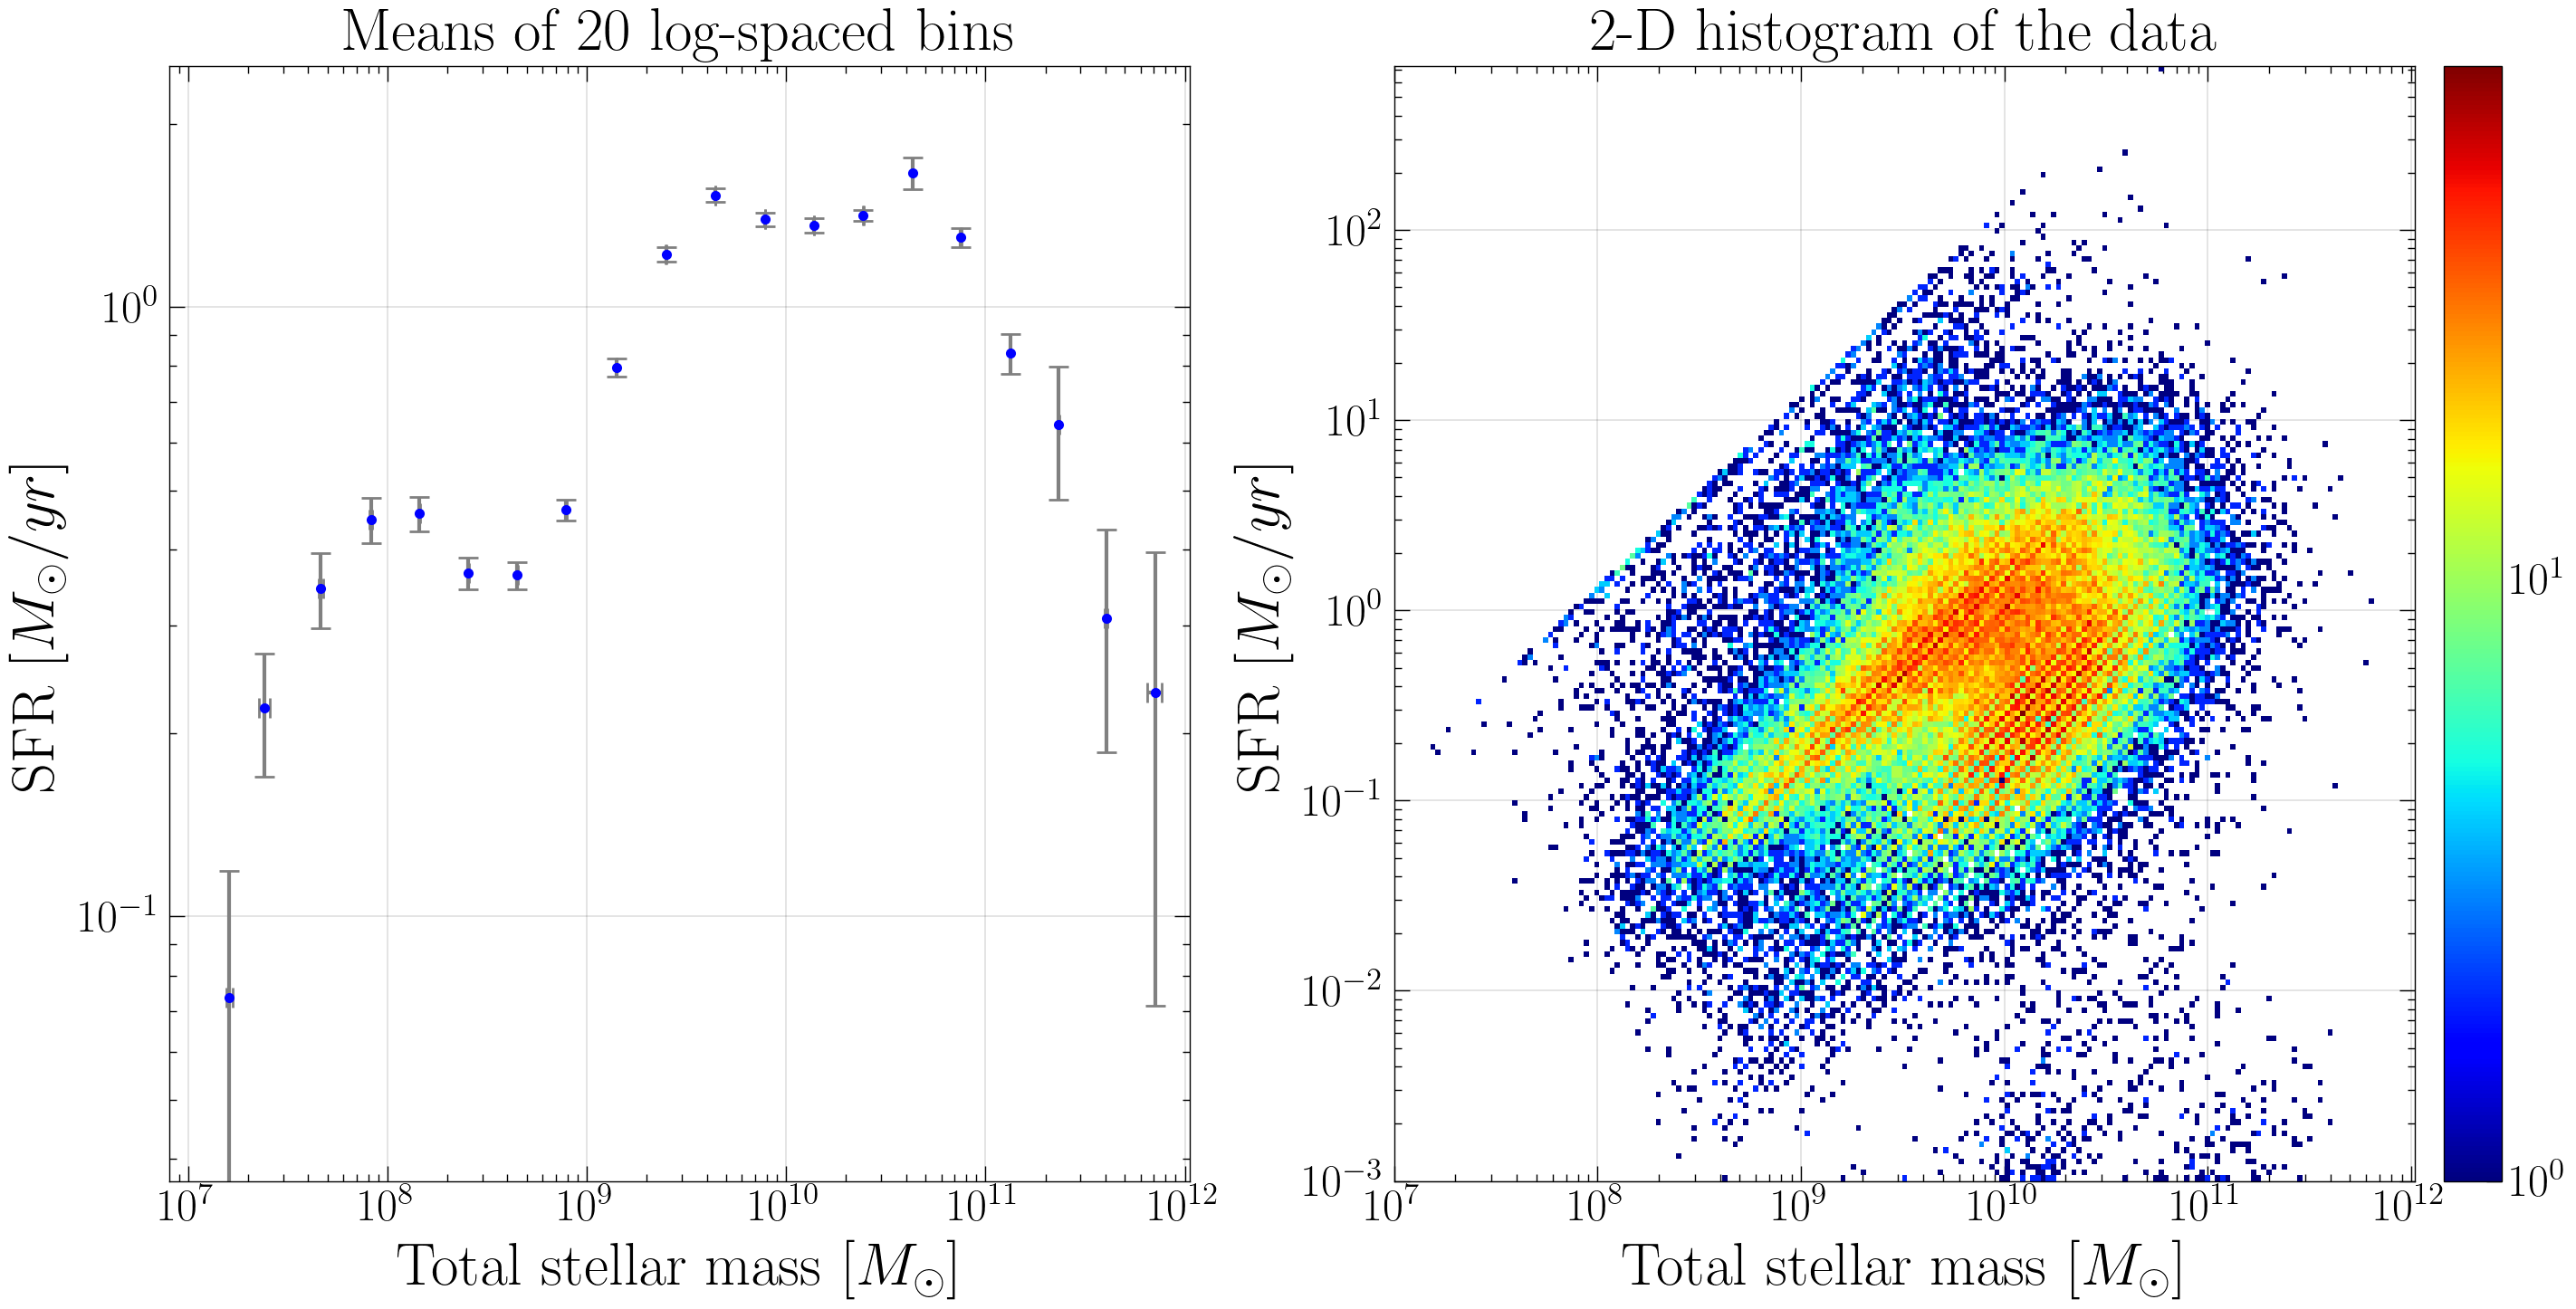

bins occupation = [    5     6    27   109   428  1111  2366  3812  5991  8702 11583 14287
 15815 13270  8452  4202  1664   530    90     7]


In [4]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']

fig, ax, statistics, hist = Plot(x_data, y_data, 'Total stellar mass $[M_\odot]$', 'SFR $[M_\odot/yr]$', xbins=20, x_min=1e7, y_min=1e-3);
print(f'bins occupation = {statistics[:,0].astype(int)}')

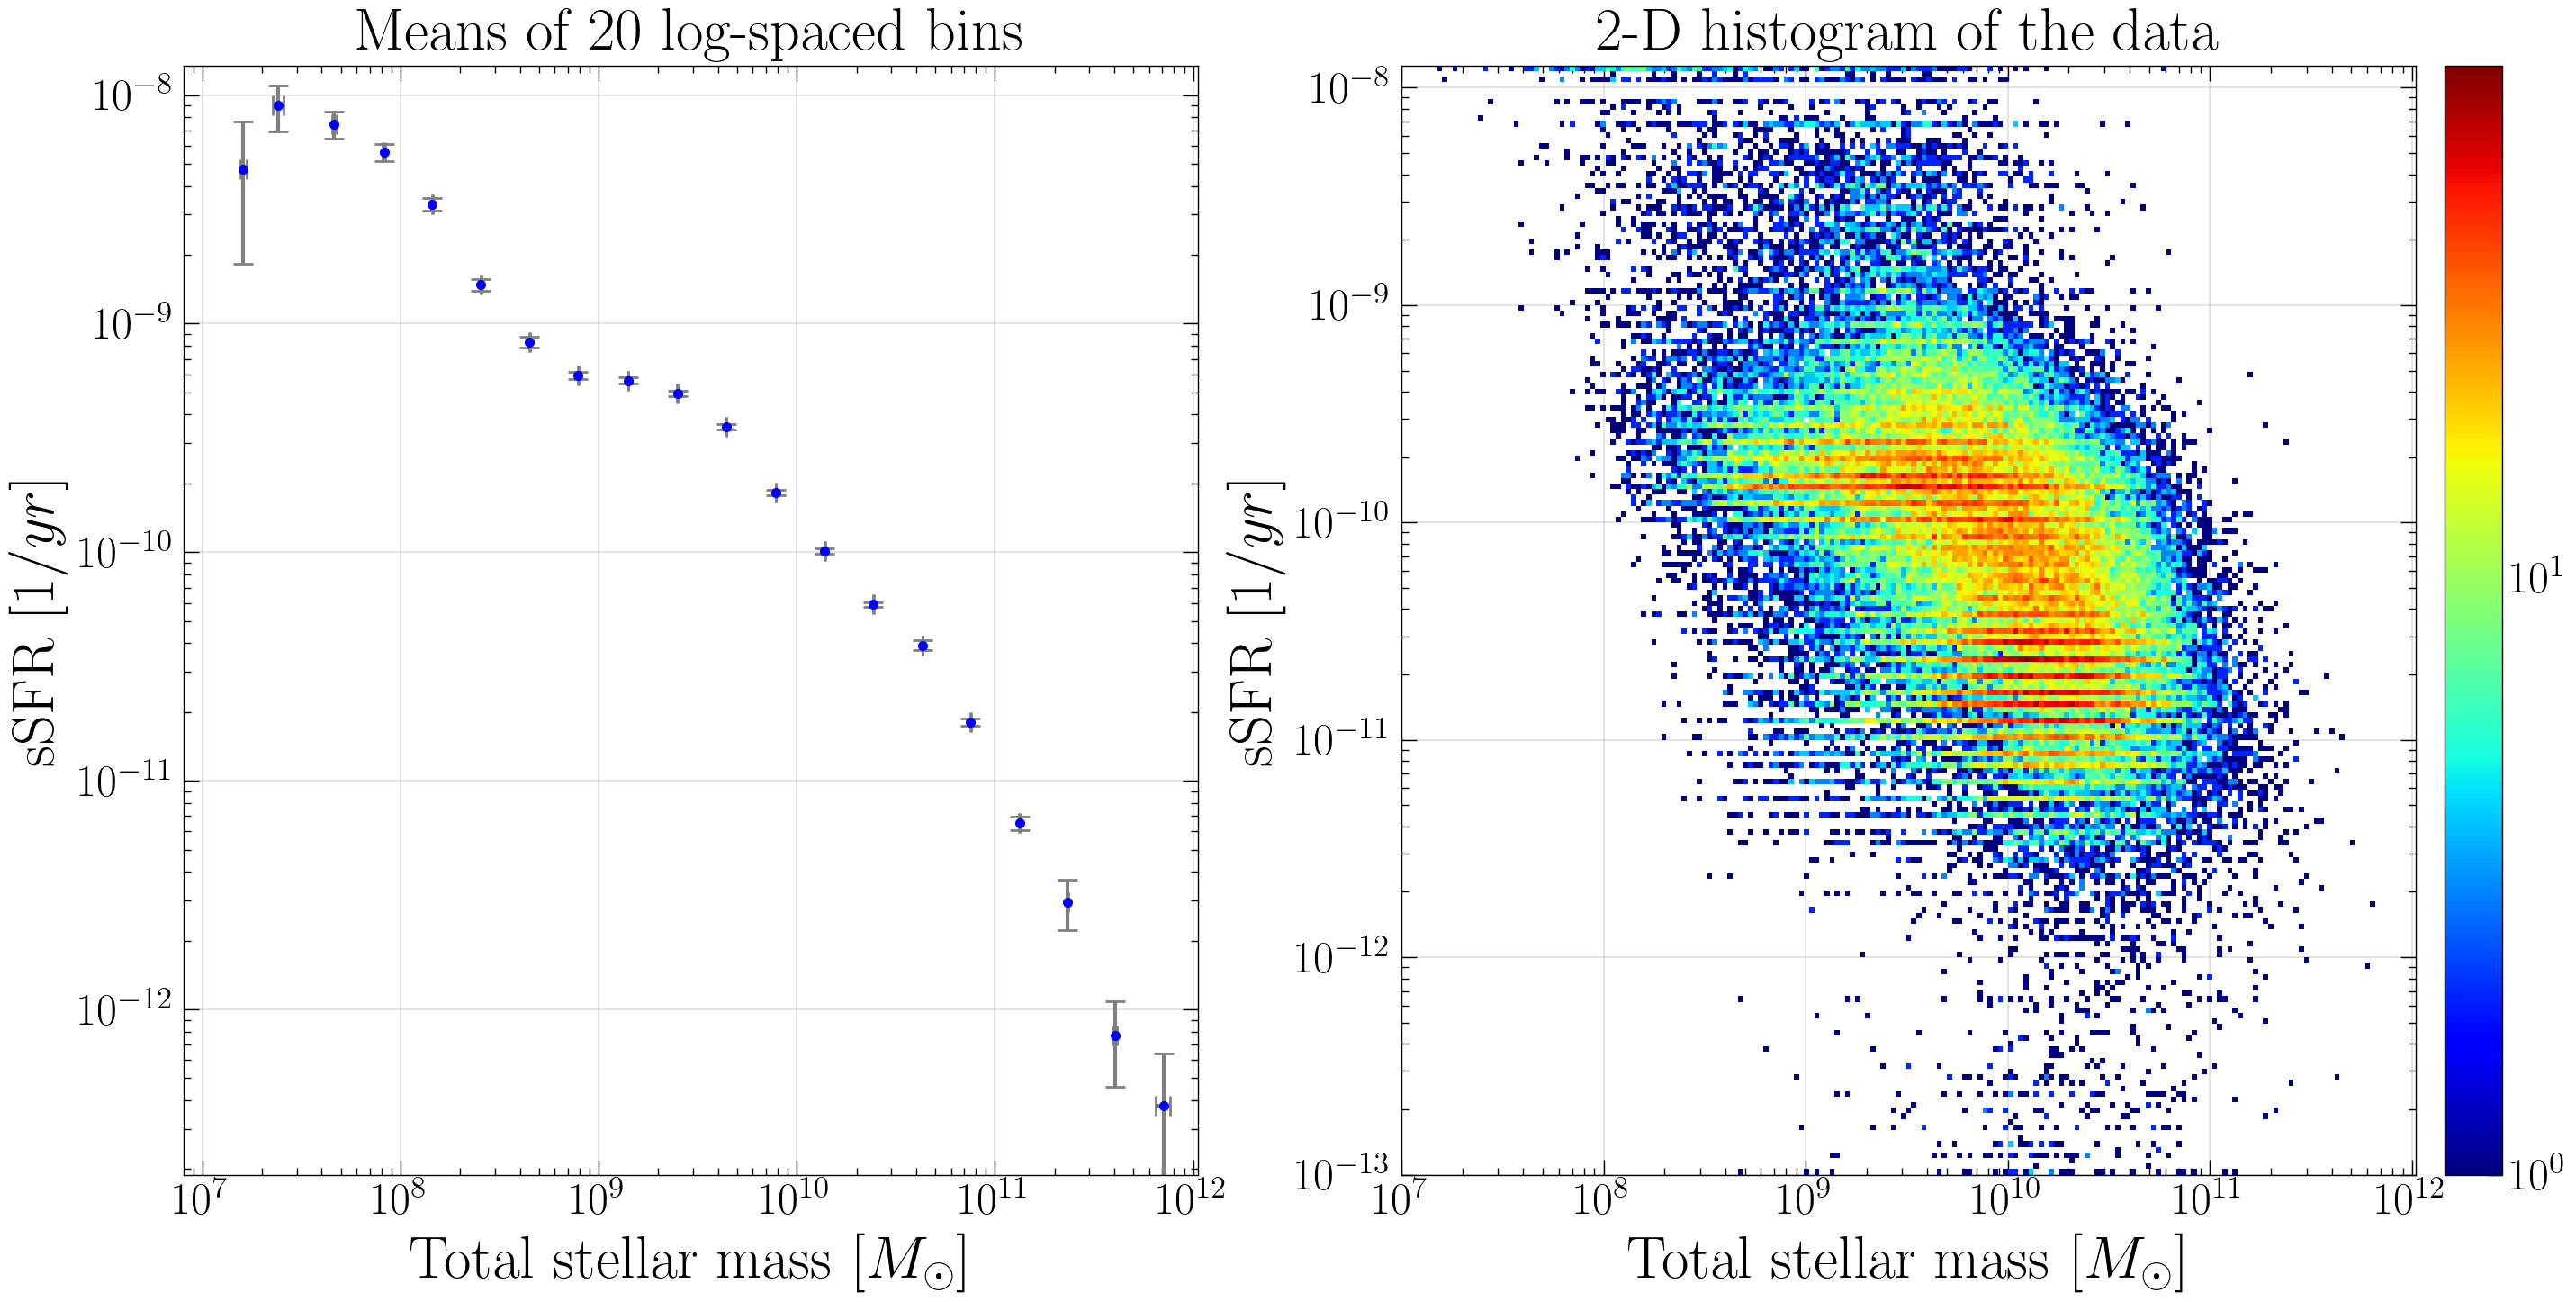

bins occupation = [    5     6    27   109   428  1111  2366  3812  5991  8702 11583 14287
 15815 13270  8452  4202  1664   530    90     7]


In [5]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']
    
fig, ax, statistics, hist = Plot(x_data, y_data, 'Total stellar mass $[M_\odot]$', 'sSFR $[1/yr]$', xbins=20, hist2d_nbins = 200, x_min=1e7, y_min=1e-13);
print(f'bins occupation = {statistics[:,0].astype(int)}')

# Clustering 

## 1) KMeans

[KMeans Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [6]:
from sklearn.cluster import KMeans

X = np.array([np.log10(x_data), np.log10(y_data)]).T

n_clusters = 2
#centers = np.array([[9.3, 0.2], [10.1, 0.01]]) 
clf = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', verbose=True)
clf.fit(X)
labels = clf.predict(X)  

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
def PlotClusters(labels):
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique[labels_unique >= 0])
    print(f'labels = {labels_unique}')
    print("number of estimated clusters :", n_clusters)
    
    fig = plt.figure(figsize=(12,8))
    plt.scatter(X[labels==-1,0], X[labels==-1,1], color='gray', alpha=0.5)
    for i in range(n_clusters):
        plt.scatter(X[labels==i,0], X[labels==i,1], alpha=0.5)
    plt.xlabel('Total stellar mass $[M_\odot]$')
    plt.ylabel('sSFR $[1/yr]$')
    
    return fig

labels = [0 1]
number of estimated clusters : 2


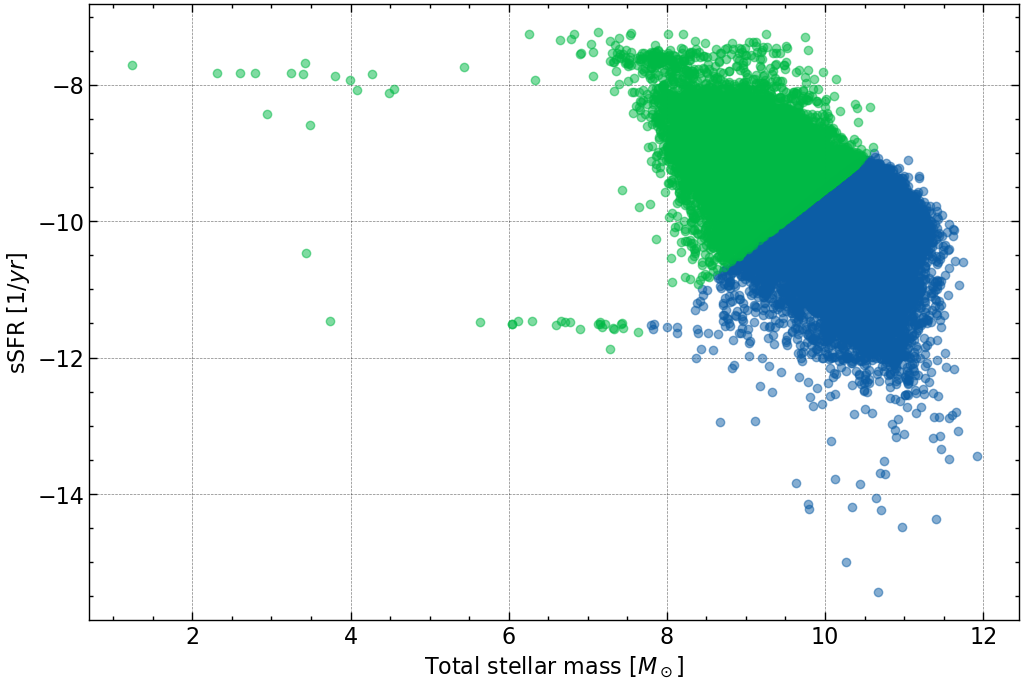

In [ ]:
fig = PlotClusters(labels)

## 2) MeanShift

[MeanShift Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)

[estimate_bandwidth Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.estimate_bandwidth.html)

In [ ]:
from sklearn.cluster import MeanShift
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
bandwidth = 0.7 # Determined by using sklearn.cluster.estimate_bandwidth()

#from sklearn.cluster import estimate_bandwidth
#bandwidth = estimate_bandwidth(X, n_jobs=int(mp.cpu_count()/2)) # This takes a long time...beware

In [ ]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True, n_jobs=int(mp.cpu_count()/2))
ms.fit(scaler.fit_transform(X))

labels = ms.labels_

labels = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
number of estimated clusters : 24


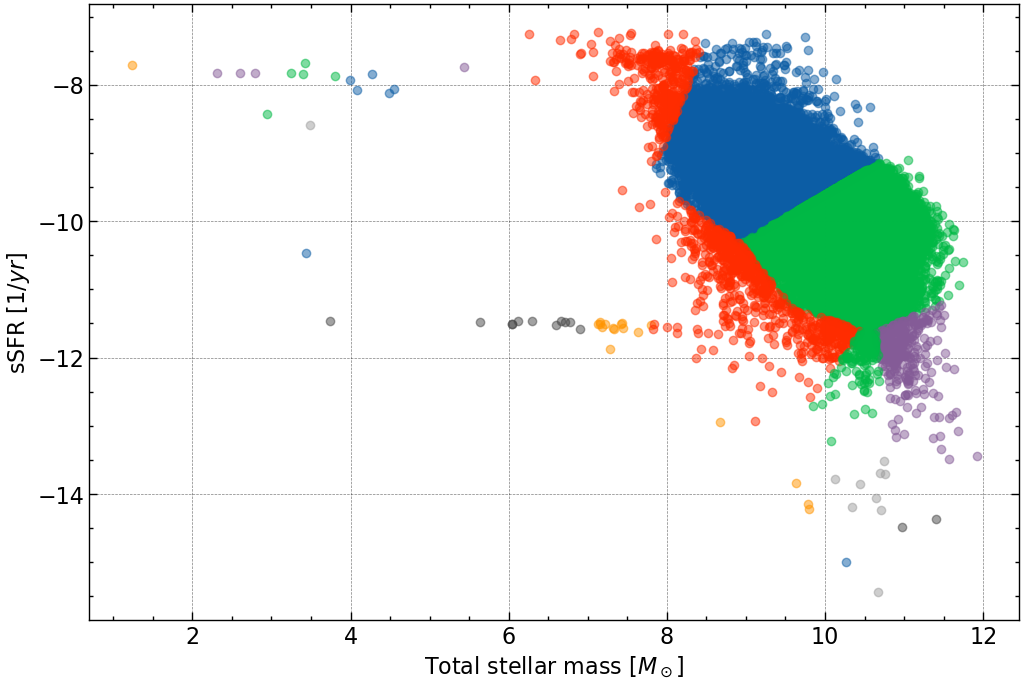

In [ ]:
fig = PlotClusters(labels)

## 3) DBSCAN

[DBSCAN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

The computation takes a while

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = False

if dbscan:
    # Initialize DBSCAN object
    dbscan = DBSCAN(eps=0.5, min_samples=500, n_jobs=1)

    # Fit model on data
    labels = dbscan.fit_predict(X)

labels = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
number of estimated clusters : 24


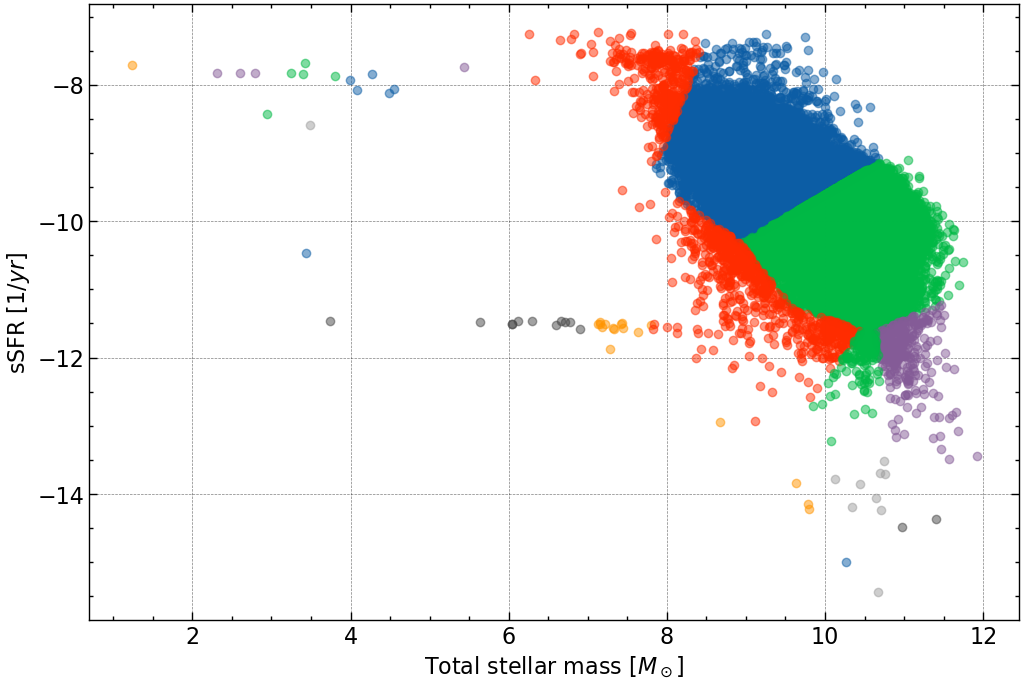

In [ ]:
fig = PlotClusters(labels)

# Bimodal gaussian fit

IndexError: cannot do a non-empty take from an empty axes.

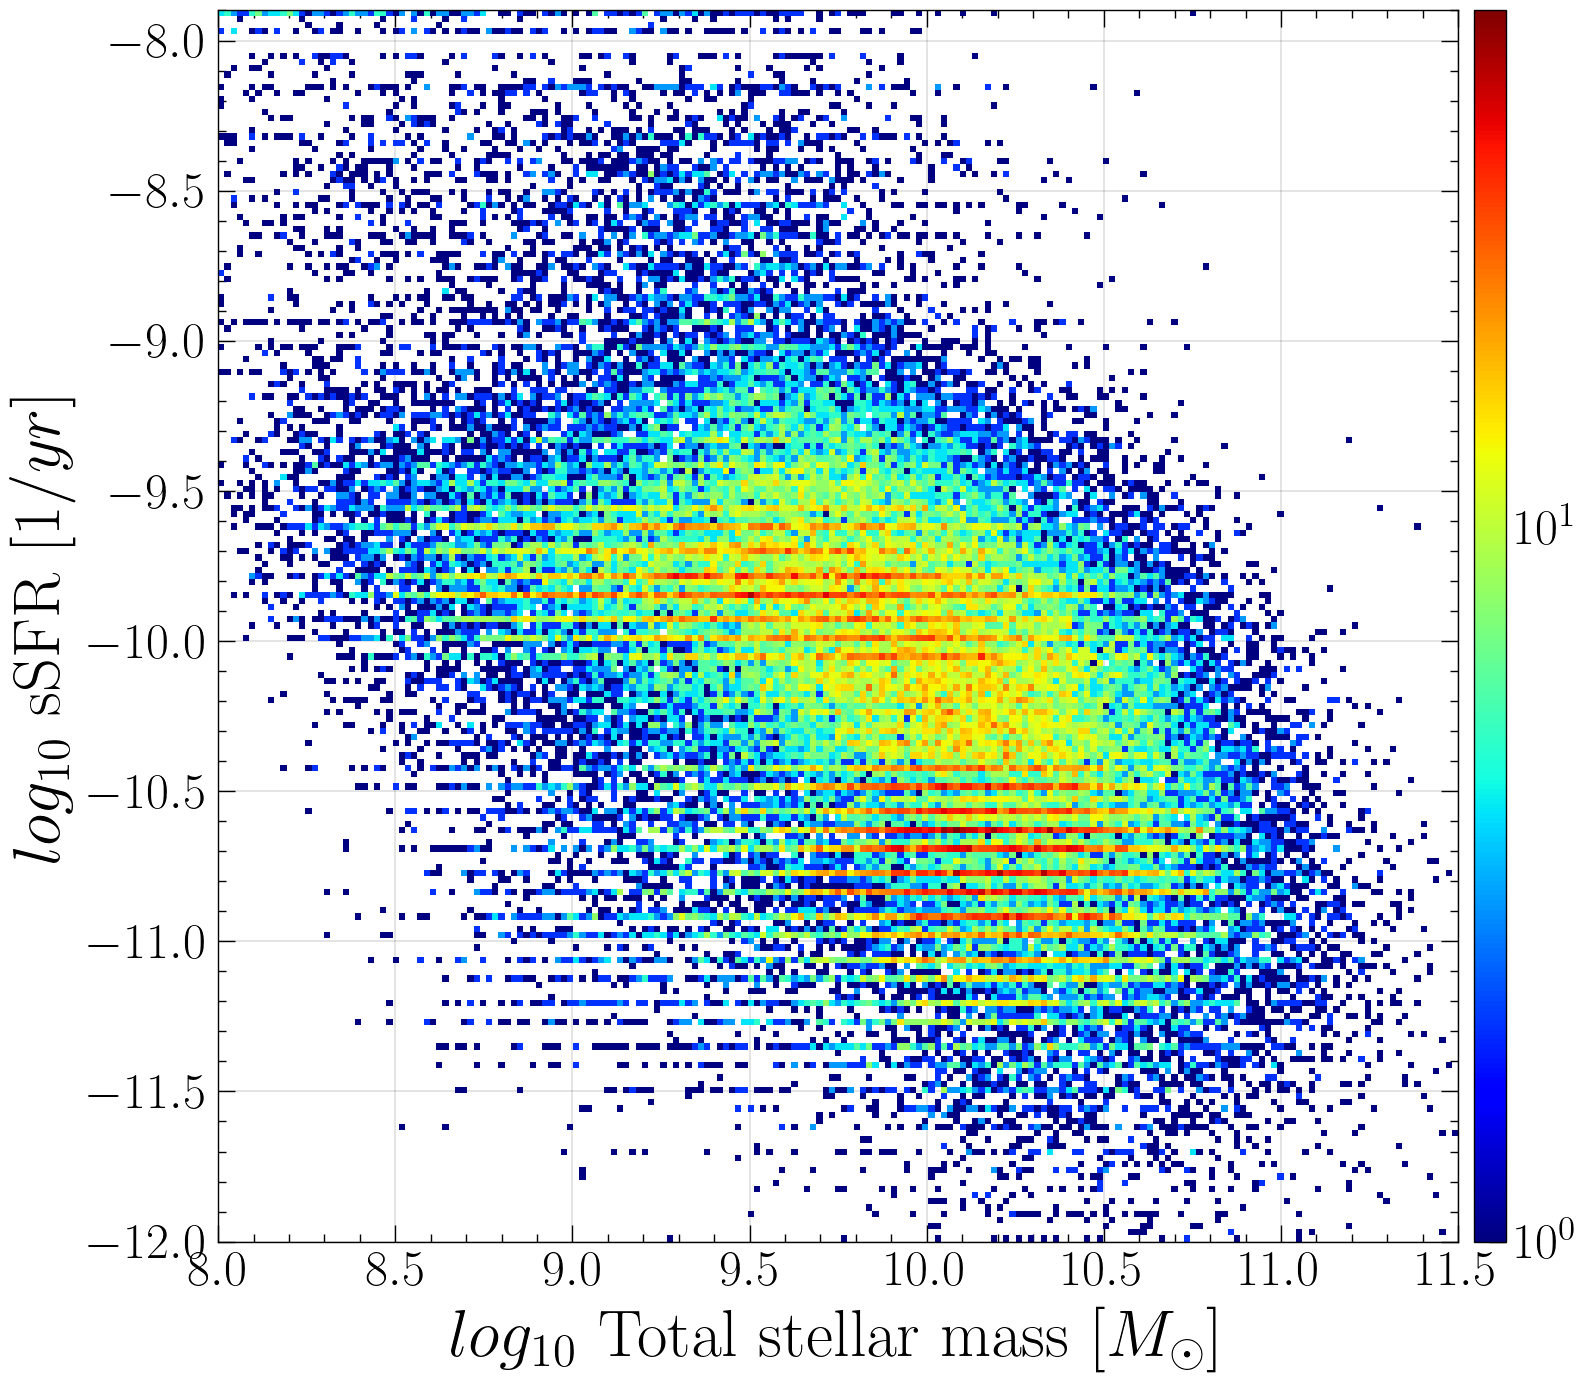

In [18]:
# Base code drawn from Ivezic, Figure 3.22, edited by G. Richards to simplify the example

from matplotlib.patches import Ellipse
from astroML.stats import fit_bivariate_normal

x_data = np.log10(results['best.stellar.m_star'])
y_data = np.log10(results['best.sfh.sfr10Myrs']/results['best.stellar.m_star'])

x_min = 7
x_max = np.max(x_data)
y_min = -13
y_max = np.max(y_data)
hist2d_nbins = 200

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

binx = np.linspace(start=x_min, stop=x_max, num=hist2d_nbins)
biny = np.linspace(start=y_min, stop=y_max, num=hist2d_nbins)
hist = ax.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
cax = fig.add_axes([0.91, 0.11, 0.02, 0.77])
fig.colorbar(hist[3], cax=cax)

y_separator = np.log10(14093985870.13291)
ax.axhline(y_separator, color='red', ls='--', label='Separation line')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
ax.set_ylabel('$log_{10}$ sSFR $[1/yr]$');


# Fit the main sequence with a bivariate normal distribution and plot it via robust estimators
mask = y_data >= y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=2, 
                         ec='black', fc='none'))
    
    
# Fit the passive region with a bivariate normal distribution and plot it via robust estimators
mask = y_data < y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=2, 
                         ec='black', fc='none'))
    
ax.legend()

IndexError: cannot do a non-empty take from an empty axes.

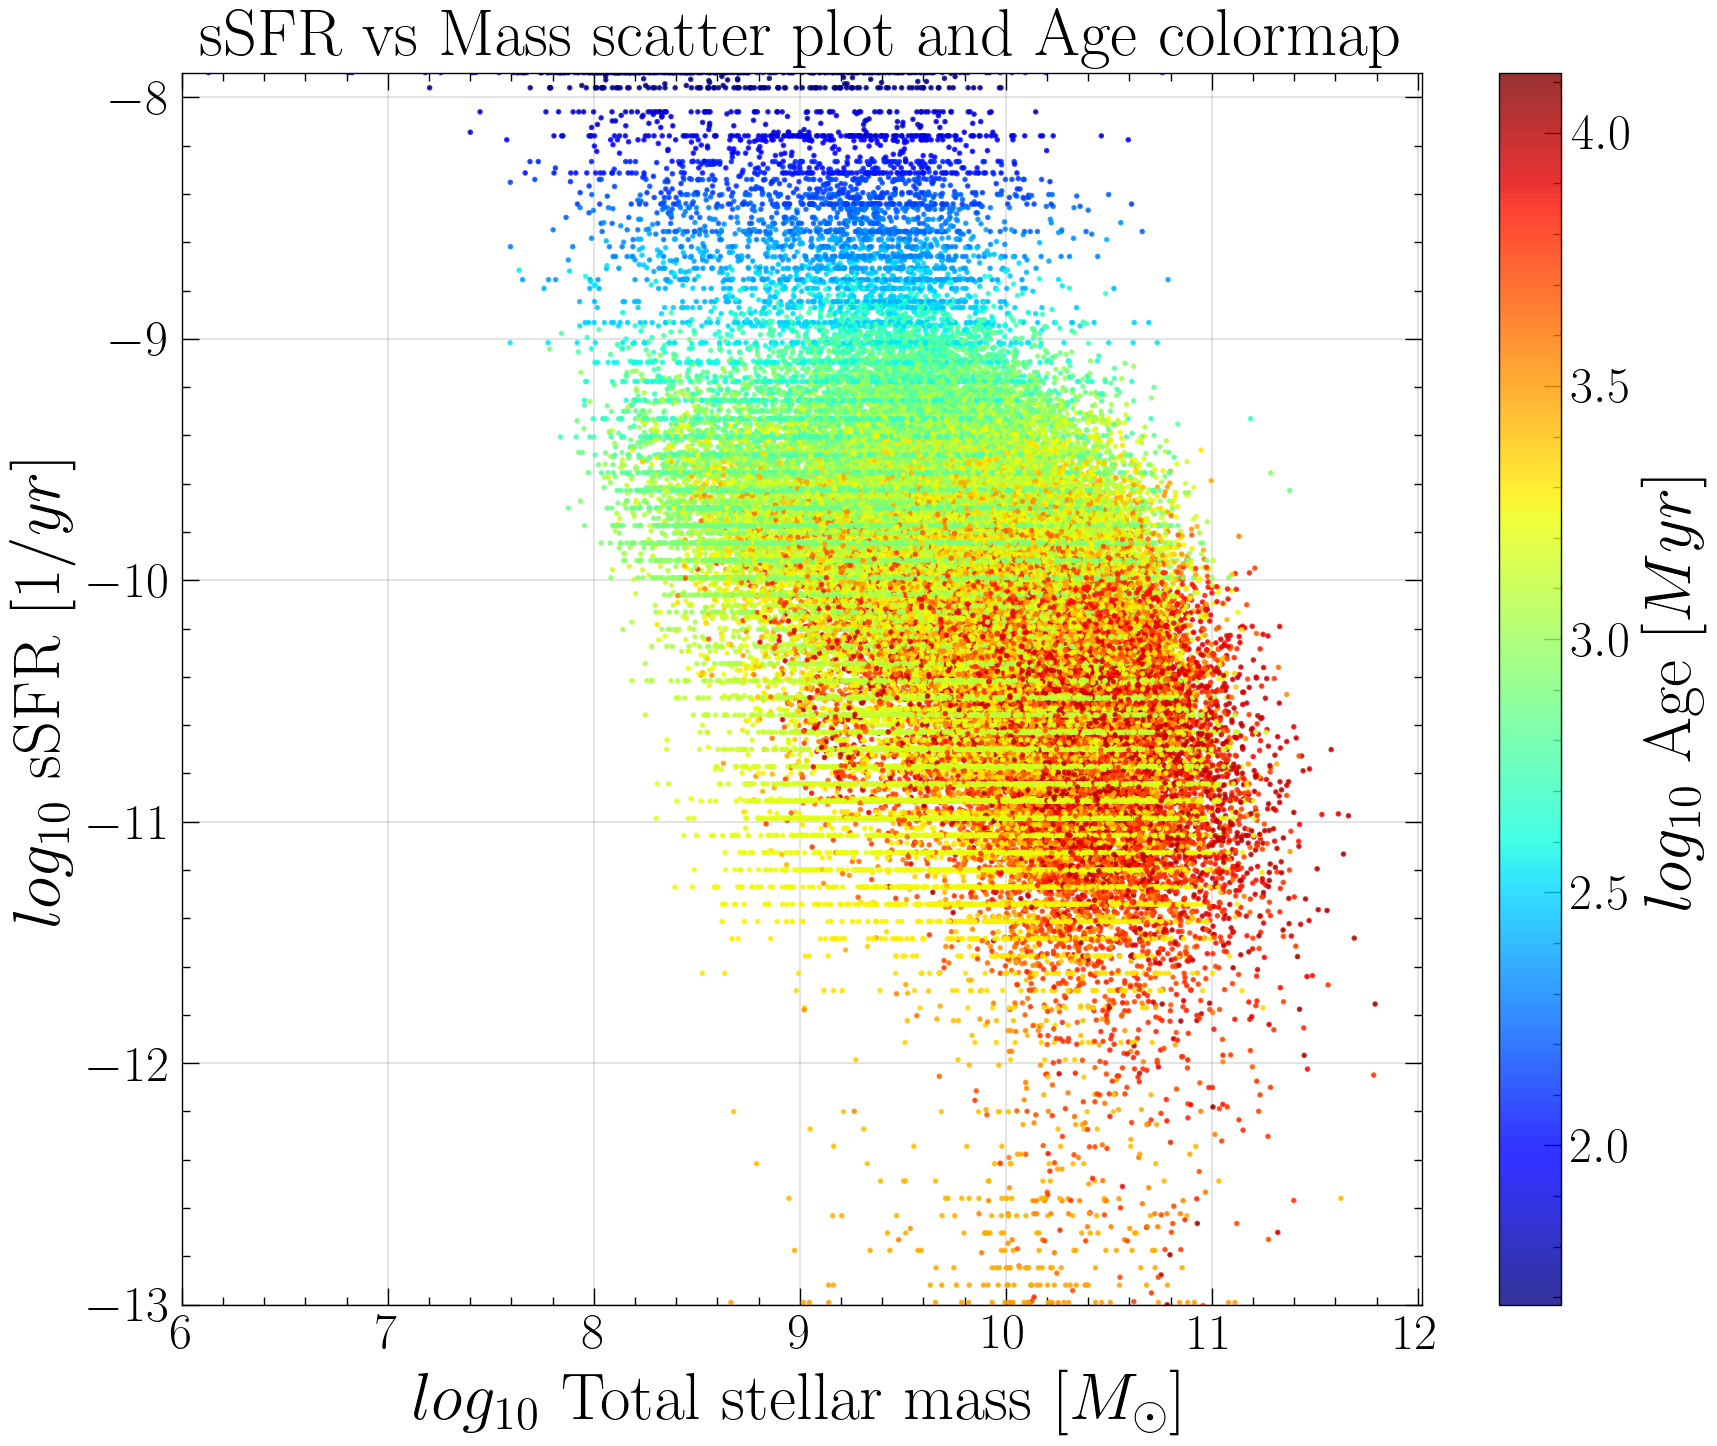

In [19]:
#x_data = np.log10(results['best.stellar.m_star'])
#y_data = np.log10(results['bayes.sfh.sfr10Myrs']/results['best.stellar.m_star'])
colormap_age = np.log10(results['best.stellar.age_m_star'])

#plt.rcParams['figure.figsize'] = [10 , 8]
plt.rcParams['figure.figsize'] = [10 , 8]
fig, ax = plt.subplots(1, 1)

x_min = 6
x_max = np.max(x_data)
y_min = -13
y_max = np.max(y_data)

plt.title(f'sSFR vs Mass scatter plot and Age colormap')
plt.scatter(x_data, y_data, c=colormap_age, cmap=plt.cm.jet, alpha=0.8, s=1)
plt.colorbar(label='$log_{{10}}$ Age $[Myr]$')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
plt.ylabel('$log_{10}$ sSFR $[1/yr]$');



# Fit the main sequence with a bivariate normal distribution and plot it via robust estimators
mask = y_data >= y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=2, 
                         ec='black', fc='none'))
    
    
# Fit the passive region with a bivariate normal distribution and plot it via robust estimators
mask = y_data < y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=2, 
                         ec='black', fc='none'))

# 3D Histogram

In [ ]:
run_3dHist = False

if run_3dHist:
    
    # Initialize the data (in log-scale) and the boundaries
    x_data = np.log10(results['best.stellar.m_star'])
    y_data = np.log10(results['best.sfh.sfr10Myrs']/results['best.stellar.m_star'])

    x_min = 6
    x_max = np.max(x_data)
    y_min = -13
    y_max = np.max(y_data)
    hist2d_nbins = 200

    # Make the 3d plot interactive
    %matplotlib widget

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Initialize the histogram
    binx = np.linspace(start=x_min, stop=x_max, num=hist2d_nbins)
    biny = np.linspace(start=y_min, stop=y_max, num=hist2d_nbins)
    hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=(binx, biny))

    # Positions of the bars
    xpos, ypos = np.meshgrid((xedges[:-1]+xedges[1:])/2, (yedges[:-1]+yedges[1:])/2)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like (xpos)

    # Sizes of the bars
    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()

    # Colormap: scale each z to [0,1] and get their rgb values
    cmap = matplotlib.colormaps.get_cmap('jet') 
    rgba = [cmap((k-np.min(dz))/np.max(dz)) for k in dz] 

    # Set the height of the bars in log-scale
    for i in range(len(dz)):
        if dz[i]>0: dz[i] = np.log10(dz[i])

    # Plot the 3D histogram
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
    ax.set_ylabel('$log_{10}$ sSFR $[1/yr]$');